In [13]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Preprocessing the data

In [25]:
BUFFER_SIZE = 70_000 
BATCH_SIZE = 128
NUM_EPOCHS = 20

In [26]:
mnist_dataset, mnist_info = tfds.load(name='mnist', with_info=True, as_supervised=True)

In [27]:
mnist_train, mnist_test = mnist_dataset['train'], mnist_dataset['test']

In [28]:
def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.

    return image, label

In [29]:
train_and_validation_data = mnist_train.map(scale)
test_data = mnist_test.map(scale)

In [30]:
num_validation_samples = 0.1 * mnist_info.splits['train'].num_examples
num_validation_samples = tf.cast(num_validation_samples, tf.int64)

In [31]:
num_test_samples = mnist_info.splits['test'].num_examples
num_test_samples = tf.cast(num_test_samples, tf.int64)

In [32]:
train_and_validation_data = train_and_validation_data.shuffle(BUFFER_SIZE)

In [33]:
train_data = train_and_validation_data.skip(num_validation_samples)
validation_data = train_and_validation_data.take(num_validation_samples)

In [34]:
train_data = train_data.batch(BATCH_SIZE)
validation_data = validation_data.batch(num_validation_samples)
test_data = test_data.batch(num_test_samples)

# Creating the model and training it

In [36]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(50, 5, activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2,)),
    tf.keras.layers.Conv2D(50, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2,)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10)
])

In [37]:
model.summary(line_length = 75)

Model: "sequential"
___________________________________________________________________________
 Layer (type)                    Output Shape                  Param #     
 conv2d (Conv2D)                 (None, 24, 24, 50)            1300        
                                                                           
 max_pooling2d (MaxPooling2D)    (None, 12, 12, 50)            0           
                                                                           
 conv2d_1 (Conv2D)               (None, 10, 10, 50)            22550       
                                                                           
 max_pooling2d_1 (MaxPooling2D)  (None, 5, 5, 50)              0           
                                                                           
 flatten (Flatten)               (None, 1250)                  0           
                                                                           
 dense (Dense)                   (None, 10)                    12510

In [38]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [39]:
model.compile(optimizer='adam',loss=loss_fn, metrics=['accuracy'])

In [40]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    mode = 'auto',    
    min_delta = 0,
    patience = 2,
    verbose = 0, 
    restore_best_weights = True
)

In [41]:
model.fit(
    train_data,
    epochs= NUM_EPOCHS,
    callbacks = [early_stopping],
    validation_data = validation_data,
    verbose = 2
)

Epoch 1/20
422/422 - 32s - loss: 0.2643 - accuracy: 0.9258 - val_loss: 0.0705 - val_accuracy: 0.9802 - 32s/epoch - 75ms/step
Epoch 2/20
422/422 - 27s - loss: 0.0715 - accuracy: 0.9786 - val_loss: 0.0545 - val_accuracy: 0.9840 - 27s/epoch - 65ms/step
Epoch 3/20
422/422 - 30s - loss: 0.0523 - accuracy: 0.9844 - val_loss: 0.0377 - val_accuracy: 0.9890 - 30s/epoch - 71ms/step
Epoch 4/20
422/422 - 26s - loss: 0.0432 - accuracy: 0.9867 - val_loss: 0.0302 - val_accuracy: 0.9915 - 26s/epoch - 62ms/step
Epoch 5/20
422/422 - 25s - loss: 0.0358 - accuracy: 0.9889 - val_loss: 0.0197 - val_accuracy: 0.9945 - 25s/epoch - 59ms/step
Epoch 6/20
422/422 - 24s - loss: 0.0320 - accuracy: 0.9902 - val_loss: 0.0341 - val_accuracy: 0.9892 - 24s/epoch - 58ms/step
Epoch 7/20
422/422 - 25s - loss: 0.0280 - accuracy: 0.9910 - val_loss: 0.0296 - val_accuracy: 0.9907 - 25s/epoch - 59ms/step


# Test

In [42]:
test_loss, test_accuracy = model.evaluate(test_data)

1/1 [==============================] - 1s 1s/step - loss: 0.0339 - accuracy: 0.9894


In [43]:
print('Test loss: {0: .4f}. Test accuracy: {1: .2F}%'.format(test_loss, test_accuracy*100.))

Test loss:  0.0339. Test accuracy:  98.94%


# Plotting images and the results

In [44]:
import matplotlib.pyplot as plt
import numpy as np

In [45]:
for images, labels in test_data.take(1):
    images_test = images.numpy()
    labels_test = labels.numpy()


images_plot = np.reshape(images_test, (10000,28,28))

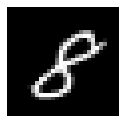

Label: 8


In [48]:
# The image to be displayed and tested
i = 4


# Plot the image
plt.figure(figsize=(2, 2))
plt.axis('off')
plt.imshow(images_plot[i-1], cmap="gray", aspect='auto')
plt.show()

# Print the correct label for the image
print("Label: {}".format(labels_test[i-1]))

1/1 [==============================] - 0s 18ms/step


<BarContainer object of 10 artists>

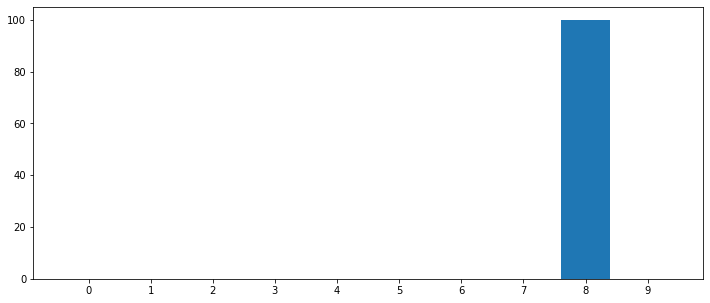

In [49]:
predictions = model.predict(images_test[i-1:i])

# Convert those predictions into probabilities
probabilities = tf.nn.softmax(predictions).numpy()
# Convert the probabilities into percentages
probabilities = probabilities*100


# Create a bar chart to plot the probabilities for each class
plt.figure(figsize=(12,5))
plt.bar(x=[1,2,3,4,5,6,7,8,9,10], height=probabilities[0], tick_label=["0","1","2","3","4","5","6","7","8","9"])